In [1]:
# GPLVM training
from mesh_to_sdf import mesh_to_voxels
import trimesh
import numpy as np

obj_names = ['Bus', 'Jeep', 'Pickup', 'Sedan', 'Suv']
voxel_resolution = 64
dct_resolution = 25

def generateAndSaveSdf(obj_name, voxel_resolution):
    mesh = trimesh.load(f'objs2/{obj_name}.obj')
    print(f'Generating {voxel_resolution}x{voxel_resolution}x{voxel_resolution} SDF for {obj_name}...')
    voxels = mesh_to_voxels(mesh, voxel_resolution)
    voxels = np.array(voxels)
    np.save(f'objs2/{obj_name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}', voxels)
    print(f'SDF for {obj_name} generated and saved.')
    return voxels


In [2]:
# # Generate (if not generated yet)
# for obj_name in obj_names:
#     generateAndSaveSdf(obj_name, voxel_resolution)

Generating 64x64x64 SDF for Bus...
SDF for Bus generated and saved.
Generating 64x64x64 SDF for Jeep...
SDF for Jeep generated and saved.
Generating 64x64x64 SDF for Pickup...
SDF for Pickup generated and saved.
Generating 64x64x64 SDF for Sedan...
SDF for Sedan generated and saved.
Generating 64x64x64 SDF for Suv...
SDF for Suv generated and saved.


In [2]:
# Load from generated & saved SDF
sdfs = []
for obj_name in obj_names:
    sdfs.append(np.load(f'objs2/{obj_name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}.npy'))
sdfs = np.array(sdfs)
sdfs.shape

(5, 64, 64, 64)

In [3]:
# 3D DCT
# 3D DCT function
import numpy as np
from scipy.fftpack import dct, idct

def dctn(x, norm="ortho"):
    for i in range(x.ndim):
        x = dct(x, axis=i, norm=norm)
    return x

def idctn(x, norm="ortho"):
    for i in range(x.ndim):
        x = idct(x, axis=i, norm=norm)
    return x

# 3D DCT the voxels
dct_trimmeds = []
for sdf in sdfs:
    dct_full = dctn(sdf)
    dct_trimmeds.append(dct_full[:dct_resolution, :dct_resolution, :dct_resolution])

In [4]:
# GPLVM Training
from mygplvm import MyGPLVM

gplvm = MyGPLVM()
dct_flatteneds = []
for dct_trimmed in dct_trimmeds:
    dct_flatteneds.append(dct_trimmed.flatten())
gplvm.simple_gplvm(dct_flatteneds, 'vehicle_models', latent_dimension = 2, epsilon = 0.001, maxiter = 50)

         Current function value: 92231.596252
         Iterations: 3
         Function evaluations: 754
         Gradient evaluations: 53
time: 0.16961336135864258
alpha 1.1728706633903776
beta 0.6048697071086271
gamma 0.999999256289598


c:\ProgramData\anaconda3\envs\python310\lib\site-packages\scipy\optimize\_optimize.py:1698: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, **opts)


array([[ 51.1509285 ,   7.4637723 ],
       [-42.88325882,  12.87237644],
       [ 13.78207779,  -2.41252542],
       [-13.68172067, -10.06782338],
       [ -8.36767394,  -7.85583403]])

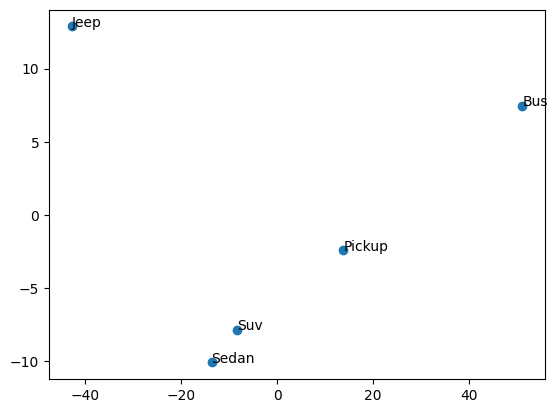

In [5]:
import matplotlib.pyplot as plt

# Scatter plot latent variable
fig, ax = plt.subplots()
ax.scatter(gplvm.X[:, 0], gplvm.X[:, 1])

for i, txt in enumerate(obj_names):
    ax.annotate(txt, (gplvm.X[i, 0], gplvm.X[i, 1]))

In [7]:
import skimage

dct_25_flat = gplvm.recall([-13.68171972, -10.0678005 ])
dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution + 2), (0, voxel_resolution - dct_resolution + 2), (0, voxel_resolution - dct_resolution + 2)))
print(dct_full.shape)

voxels_idct = idctn(dct_full)
voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])
mc_mesh.show()

(66, 66, 66)


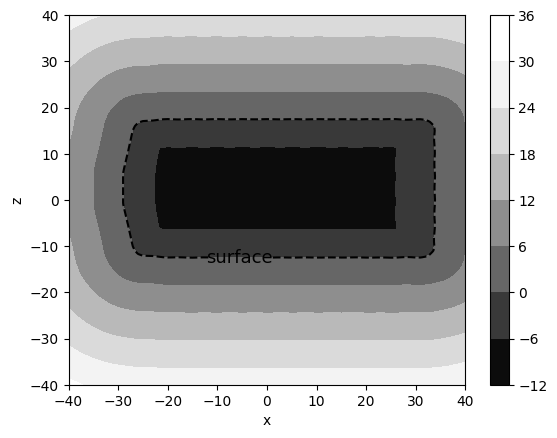

In [41]:
import pytorch_volumetric as pv
import pytorch_kinematics as pk
import torch
from myoptimization2 import MyOptimization2
mo2 = MyOptimization2()
sdf = mo2.reconstruct(gplvm, [-42.88325882,  12.87237549], dct_resolution, voxel_resolution)
# tsf = pk.RotateAxisAngle(90, axis='x')
# tsf = pk.Translate(x = 0, y = 0, z = 0)
# tsf = pk.Scale()
tsf = pk.Transform3d(matrix=torch.asarray([
    [1.0, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]))
sdf = pv.ComposedSDF([sdf, sdf], tsf.stack(tsf))

query_range = np.array([
            [-40, 40],
            [0, 0],
            [-40, 40],
        ])
result = pv.draw_sdf_slice(sdf, query_range, resolution=80/256)

In [42]:
result[2]

tensor([[-4.0000e+01, -1.7734e-06, -4.0000e+01],
        [-4.0000e+01, -2.2150e-06, -3.9688e+01],
        [-4.0000e+01,  2.0166e-06, -3.9375e+01],
        ...,
        [ 4.0000e+01, -3.8017e-07,  3.9375e+01],
        [ 4.0000e+01,  4.0737e-07,  3.9688e+01],
        [ 4.0000e+01,  5.5633e-07,  4.0000e+01]])

In [60]:
result[1]

tensor([[-0.4487,  0.0962, -0.8885],
        [-0.4528,  0.0970, -0.8863],
        [-0.4568,  0.0979, -0.8841],
        ...,
        [ 0.2828,  0.0430,  0.9582],
        [ 0.2829,  0.0424,  0.9582],
        [ 0.2829,  0.0419,  0.9582]])

calculating epoch 1...
lambdas: [tensor(-0.0007), tensor(2.5164), tensor(-0.8905), tensor(0.3301), tensor(-0.7565), tensor(-0.1567), tensor(1.0003)]


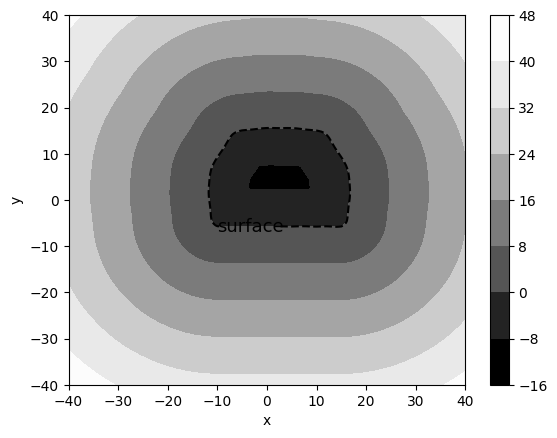

calculating epoch 2...
lambdas: [tensor(-0.0021), tensor(6.9094), tensor(-1.3022), tensor(-2.9908), tensor(-2.9422), tensor(-0.3797), tensor(0.9892)]


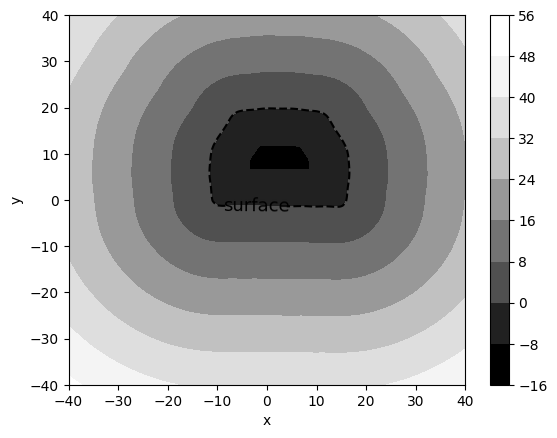

calculating epoch 3...
lambdas: [tensor(-0.0003), tensor(14.4296), tensor(-1.4752), tensor(-12.2566), tensor(-13.4745), tensor(-0.5617), tensor(0.9368)]


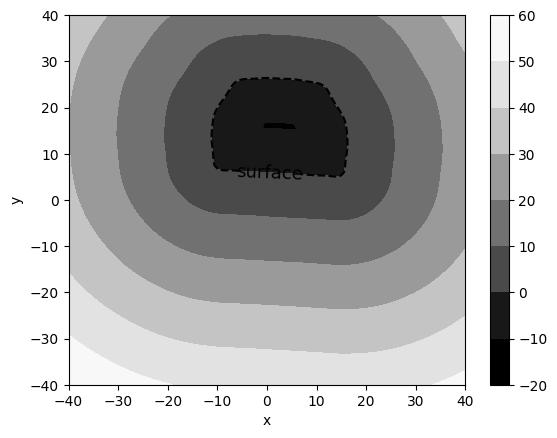

calculating epoch 4...
lambdas: [tensor(-0.0578), tensor(19.4845), tensor(-2.3308), tensor(-8.3781), tensor(56.5331), tensor(-3.2295), tensor(0.8581)]


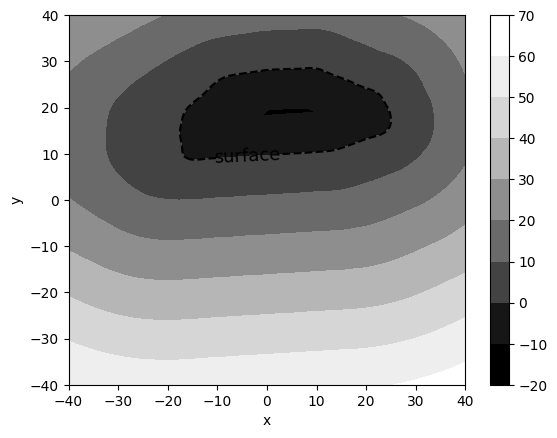

calculating epoch 5...
lambdas: [tensor(-0.0746), tensor(21.4518), tensor(-2.8030), tensor(-4.0455), tensor(29.8484), tensor(-0.0257), tensor(0.8129)]


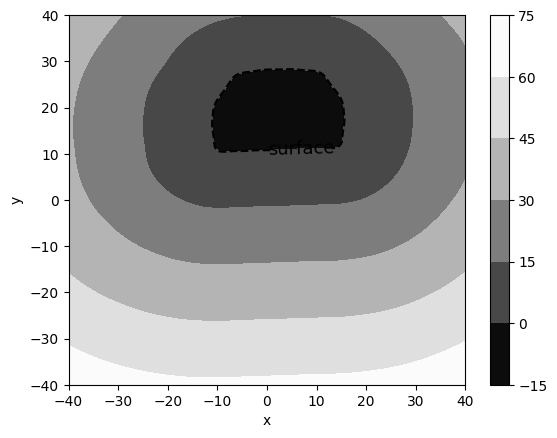

calculating epoch 6...
lambdas: [tensor(0.0175), tensor(23.2079), tensor(-2.8253), tensor(-8.7234), tensor(62.7991), tensor(-0.9305), tensor(0.7665)]


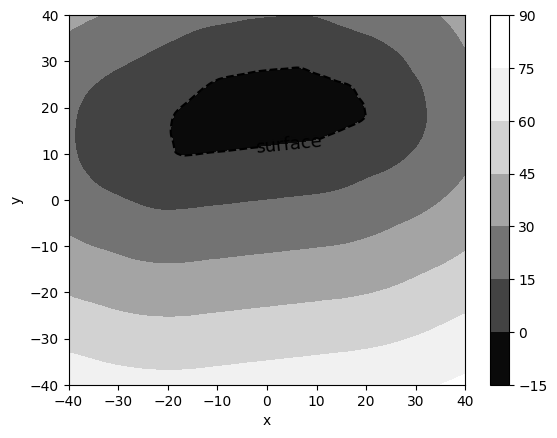

calculating epoch 7...
lambdas: [tensor(0.0544), tensor(24.2064), tensor(-2.7080), tensor(-14.4208), tensor(45.8215), tensor(-5.7399), tensor(0.7371)]


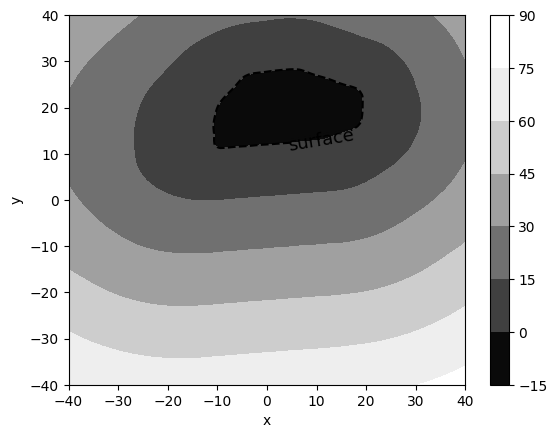

calculating epoch 8...
lambdas: [tensor(0.1653), tensor(25.2249), tensor(-3.1000), tensor(-7.9324), tensor(-35.2633), tensor(0.5057), tensor(0.7036)]


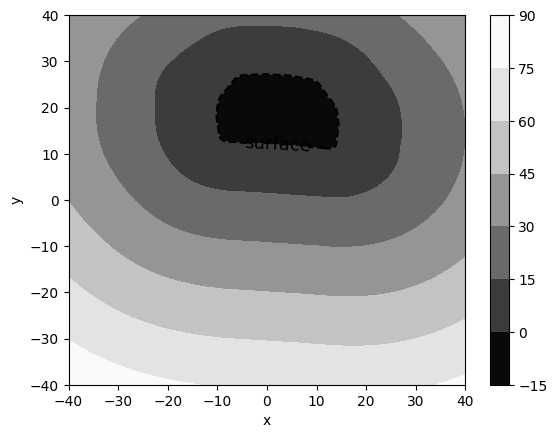

calculating epoch 9...
lambdas: [tensor(0.1807), tensor(26.6715), tensor(-3.3694), tensor(-5.8839), tensor(-34.3706), tensor(-0.9547), tensor(0.6506)]


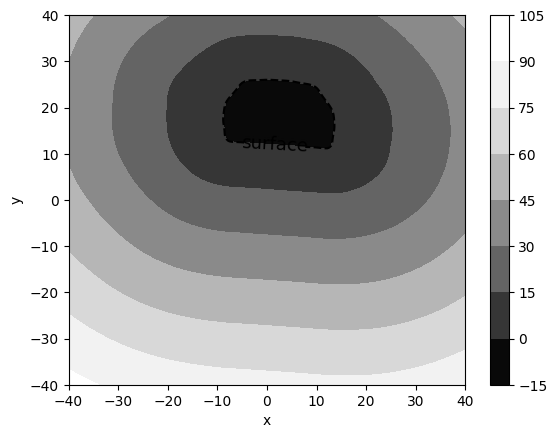

calculating epoch 10...
lambdas: [tensor(0.0923), tensor(26.9511), tensor(-3.2897), tensor(-9.0869), tensor(-38.7673), tensor(-1.2840), tensor(0.6395)]


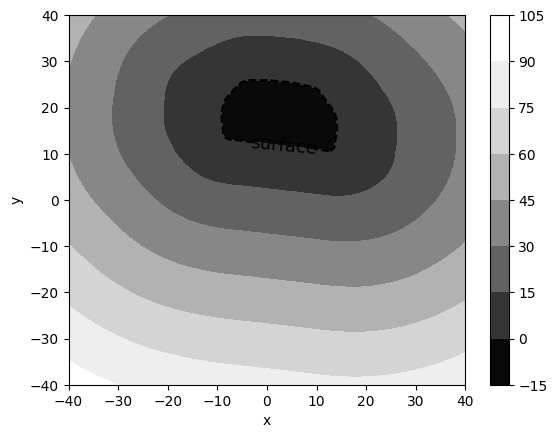

calculating epoch 11...
lambdas: [tensor(0.0094), tensor(27.7357), tensor(-3.4932), tensor(-6.3280), tensor(-27.5942), tensor(-4.9935), tensor(0.6054)]


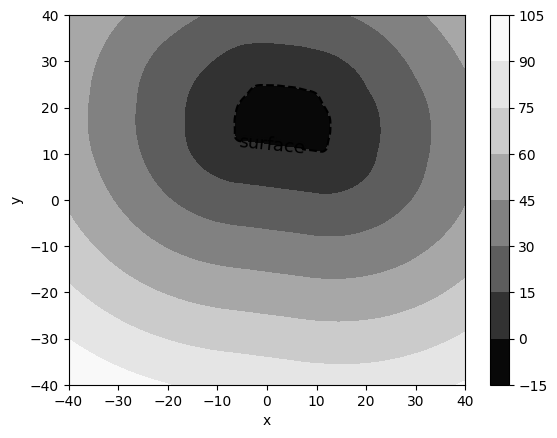

calculating epoch 12...
lambdas: [tensor(0.0675), tensor(28.7360), tensor(-3.5983), tensor(-7.0602), tensor(-34.3729), tensor(-3.4792), tensor(0.5587)]


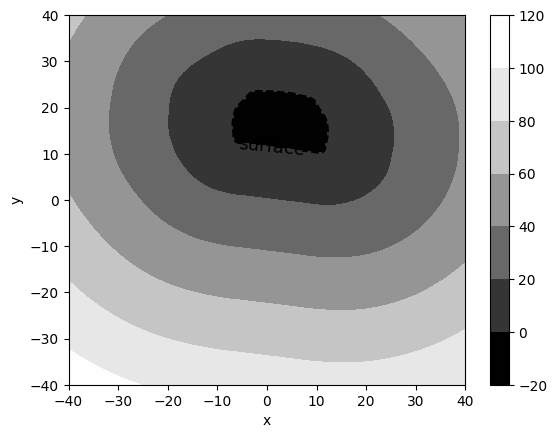

calculating epoch 13...
lambdas: [tensor(0.0820), tensor(29.1018), tensor(-3.7641), tensor(-3.6851), tensor(-36.9175), tensor(-5.1386), tensor(0.5387)]


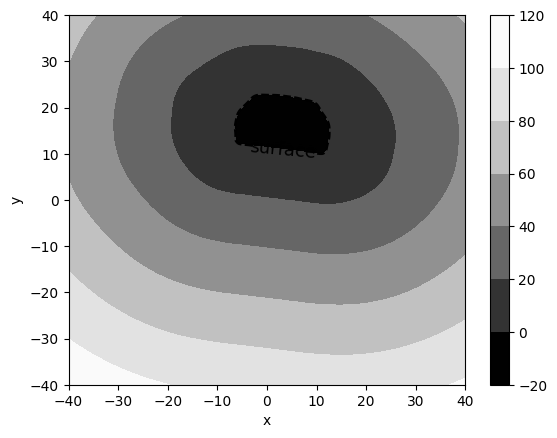

calculating epoch 14...
lambdas: [tensor(0.0506), tensor(29.8351), tensor(-3.7599), tensor(-6.6557), tensor(-62.3472), tensor(-4.2928), tensor(0.4988)]


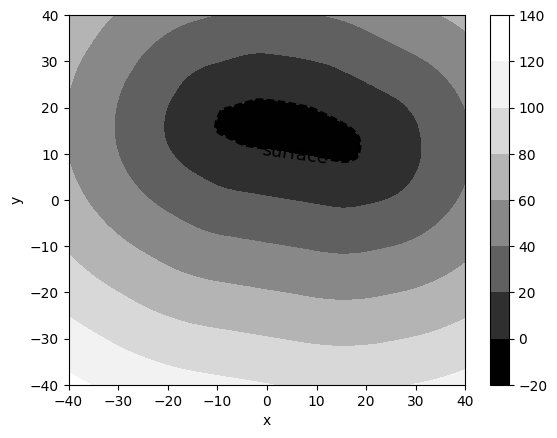

calculating epoch 15...
lambdas: [tensor(0.0463), tensor(30.1116), tensor(-3.8512), tensor(-4.9989), tensor(-65.8258), tensor(-5.8531), tensor(0.4814)]


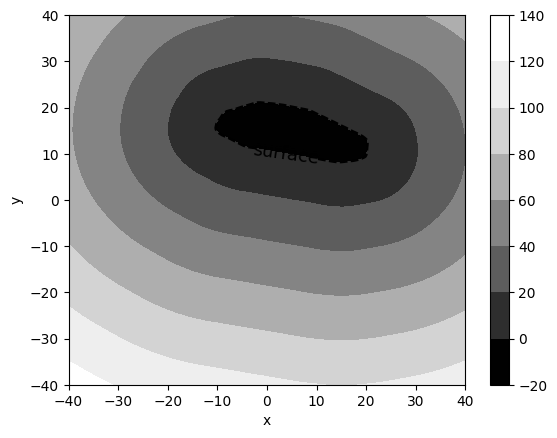

In [75]:
from PIL import Image, ImageOps
import cv2
import math
from math import sin, cos
import numpy as np
import pytorch_volumetric as pv
import pytorch_kinematics as pk
import torch


def make_square(img):
        resized = cv2.resize(img, (32, 32))
        return resized
        

def reconstruct(gplvm, latent_init, dct_resolution, voxel_resolution, num_iter = 10):
        dct_25_flat = gplvm.recall(latent_init)
        dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
        dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution)))
        voxels_idct = idctn(dct_full)
        voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
        
        mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
        mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
        mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])
        mc_mesh.apply_transform([
            [cos(math.radians(90))  , 0, sin(math.radians(90))  , 0],
            [0                      , 1, 0                      , 0],
            [-sin(math.radians(90)) , 0, cos(math.radians(90))  , 0],
            [0                      , 0, 0                      , 1]
        ])

        # convert to open3d
        o3d_mesh = mc_mesh.as_open3d

        # convert to sdf
        obj = pv.MeshObjectFactory(mesh=o3d_mesh)
        sdf0 = pv.MeshSDF(obj)
        tsf = pk.Transform3d(matrix=torch.asarray([
            [1.0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ]))
        sdf = pv.ComposedSDF([sdf0, sdf0], tsf.stack(tsf))

        ## energy function derivative calculation
        # parameters initialization
        image_resolution = 32
        learning_rate = 1
        zeta_smoothing = 3
        fu = 512
        fv = 512
        lambdas = [0. for i in range(7)]    # Tx, Ty, Tz, Rx, Ry, Rz, S; all rotation in degree
        li_mapping = {
             'Tx': 0,
             'Ty': 1,
             'Tz': 2,
             'Rx': 3,
             'Ry': 4,
             'Rz': 5,
             'S': 6
        }
        lambdas[li_mapping['S']] = 1    # set scale to 1

        # epochs
        for n in range(num_iter):
            print(f'calculating epoch {n+1}...')
            dE_dlis = [0 for i in range(len(lambdas))]

            Tx = lambdas[li_mapping['Tx']]
            Ty = lambdas[li_mapping['Ty']]
            Tz = lambdas[li_mapping['Tz']]
            Rx = math.radians(lambdas[li_mapping['Rx']])
            Ry = math.radians(lambdas[li_mapping['Ry']])
            Rz = math.radians(lambdas[li_mapping['Rz']])
            S = lambdas[li_mapping['S']]

            M = np.matrix([
                [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
                [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
                [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
                [0                                              , 0                                             , 0                 , 1]
            ])
            MI = M.I

            # iterate the image
            proj_phi = [[0 for j in range(image_resolution)] for i in range(image_resolution)]
            for u in range(image_resolution):
                # print(f'\tu = {u}')
                query_range = np.array([
                    [-40, 40],
                    [40 - (80/image_resolution) * u, 40 - (80/image_resolution) * u],
                    [-40, 40],
                ])
                coords, pts = pv.get_coordinates_and_points_in_grid(80 / image_resolution, query_range)
                sdf_val, sdf_grad = sdf(pts)
                for v in range(image_resolution):
                    rf_min_rb = 2 * input_image[u][v] - 1
                    # for i in range(len(lambdas)):
                    # lambda_i = lambdas[i]

                    sigma_lray_dlis = [0 for i in range(len(lambdas))]
                    x = (u - image_resolution//2) / image_resolution
                    y = (image_resolution//2 - v) / image_resolution
                    sigma_log_phi_l = 0
                    for l in range(image_resolution):
                        z = (l - image_resolution//2) / image_resolution
                        [x0, y0, z0, w] = np.array(MI * np.matrix([x, y, z, 1]).T).flatten()

                        phi_l = sdf_val[v + l * (image_resolution + 1)]
                        exp_phi_l_zeta = math.exp(-phi_l * zeta_smoothing)
                        sigma_log_phi_l += math.log(1 - (exp_phi_l_zeta)/(exp_phi_l_zeta + 1))

                        dl_dx = sdf_grad[v + l * (image_resolution + 1)][0]
                        dl_dy = sdf_grad[v + l * (image_resolution + 1)][1]
                        dl_dz = sdf_grad[v + l * (image_resolution + 1)][2]

                        # dx/dli, dy/dli, and dz/dli
                        dx_dlis = [
                                1,
                                0,
                                0,
                                0,
                                -x0*S*sin(Ry)*cos(Rz) + y0*S*sin(Ry)*sin(Rz) + z0*S*cos(Ry),
                                -x0*S*cos(Ry)*sin(Rz) - y0*S*cos(Ry)*cos(Rz),
                                x0*cos(Ry)*cos(Rz) - y0*cos(Ry)*sin(Rz) + z0*sin(Ry)
                        ]
                        dy_dlis = [
                                0,
                                1,
                                0,
                                x0*S*(-sin(Rx)*sin(Rz) + cos(Rx)*sin(Ry)*cos(Rz)) + y0*S*(-sin(Rx)*cos(Rz) - cos(Rx)*sin(Ry)*sin(Rz)) - z0*S*cos(Rx)*cos(Ry),
                                x0*S*(sin(Rx)*cos(Ry)*cos(Rz)) + y0*S*(-sin(Rx)*cos(Ry)*sin(Rz)) + z0*S*cos(Rx)*sin(Ry),
                                x0*S*(cos(Rx)*cos(Rz) - sin(Rx)*sin(Ry)*sin(Rz)) + y0*S*(-cos(Rx)*sin(Rz) - sin(Rx)*sin(Ry)*cos(Rz)),
                                x0*(cos(Rx)*sin(Rz) + sin(Rx)*sin(Ry)*sin(Rz)) + y0*(cos(Rx)*cos(Rz) - sin(Rx)*sin(Ry)*sin(Rz)) - z0*sin(Rx)*cos(Ry)
                        ]
                        dz_dlis = [
                                0,
                                0,
                                1,
                                x0*S*(cos(Rx)*sin(Rz) + sin(Rx)*sin(Ry)*cos(Rz)) + y0*S*(cos(Rx)*cos(Rz) - sin(Rx)*sin(Ry)*sin(Rz)) + z0*S*(-sin(Rx)*cos(Ry)),
                                x0*S*(-cos(Rx)*cos(Ry)*cos(Rz)) + y0*S*(cos(Rx)*cos(Ry)*sin(Rz)) + z0*S*(-cos(Rx)*sin(Ry)),
                                x0*S*(sin(Rx)*cos(Rz) + cos(Rx)*sin(Ry)*sin(Rz)) + y0*S*(-sin(Rx)*sin(Rz) + cos(Rx)*sin(Ry)*cos(Rz)),
                                x0*(sin(Rx)*sin(Rz) - cos(Rx)*sin(Ry)*cos(Rz)) + y0*(sin(Rx)*cos(Rz) + cos(Rx)*sin(Ry)*sin(Rz)) + z0*(cos(Rx)*cos(Ry))
                        ]
                        
                        dl_dlis = [dl_dx * dx_dlis[i] + dl_dy * dy_dlis[i] + dl_dz * dz_dlis[i] for i in range(len(lambdas))]
                        for i in range(len(dl_dlis)):
                            sigma_lray_dlis[i] += (exp_phi_l_zeta / (exp_phi_l_zeta + 1)) * dl_dlis[i]

                    
                    for i in range(len(dE_dlis)):
                        dE_dlis[i] += -rf_min_rb * math.exp(sigma_log_phi_l) * sigma_lray_dlis[i]
            #         proj_phi[u][v] = 1 - math.exp(sigma_log_phi_l)
            
            # plt.imshow(proj_phi, cmap='gray')
            # return
            # energy gradient calculation finished
            li_stepsizes = [1, 1, 1, 1, 30, 1, 0.001]
            for i in range(len(lambdas)):
                lambdas[i] = lambdas[i] + li_stepsizes[i] * dE_dlis[i] * 1

            print('lambdas:', lambdas)

            Tx = -lambdas[li_mapping['Tx']]
            Ty = -lambdas[li_mapping['Ty']]
            Tz = -lambdas[li_mapping['Tz']]
            Rx = -math.radians(lambdas[li_mapping['Rx']])
            Ry = -math.radians(lambdas[li_mapping['Ry']])
            Rz = -math.radians(lambdas[li_mapping['Rz']])
            S = 1/lambdas[li_mapping['S']]
            M = np.matrix([
                [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
                [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
                [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
                [0                                              , 0                                             , 0                 , 1.0]
            ])
            MI = M.I

            tsf = pk.Transform3d(matrix=torch.asarray(M.tolist()))
            sdf = pv.ComposedSDF([sdf0, sdf0], tsf.stack(tsf))
            query_range = np.array([
                        [-40, 40],
                        [-40, 40],
                        [0, 0],
                    ])
            result = pv.draw_sdf_slice(sdf, query_range, resolution=80/256)
        
        return lambdas


        
input_image = cv2.imread('input_images/sedan1.png', cv2.IMREAD_GRAYSCALE)
input_image = make_square(input_image)
input_image = (255 - input_image) / 255
# plt.imshow(input_image, cmap='gray')

lambdas = reconstruct(gplvm, [-13.68171972, -10.0678005 ], dct_resolution, voxel_resolution, num_iter=15)